In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder


## Read and transform data

In [2]:
# Directory containing CSV files
directory = 'Small LCL Data'

# List to store dataframes
dfs = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        # Read CSV file
        partial_df = pd.read_csv(filepath)
        # Append dataframe to the list
        dfs.append(partial_df)

# Combine all dataframes into one (optional)
df = pd.concat(dfs, ignore_index=True)

df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005251,Std,2013-12-19 20:00:00.0000000,0.347
1,MAC005251,Std,2013-12-19 20:30:00.0000000,0.293
2,MAC005251,Std,2013-12-19 21:00:00.0000000,0.284
3,MAC005251,Std,2013-12-19 21:30:00.0000000,0.227
4,MAC005251,Std,2013-12-19 22:00:00.0000000,0.397


In [3]:
# Edit dataframe for easy consumption
# 1. Rename and set KWH consumption variable to numeric
df.rename(columns={'KWH/hh (per half hour) ':'kwh_hh'}, inplace=True)
df['kwh_hh']= pd.to_numeric(df['kwh_hh'], errors='coerce')

# 2. DateTime var to pandas datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df.stdorToU.value_counts()

stdorToU
Std    134148703
ToU     33783771
Name: count, dtype: int64

In [5]:
df.kwh_hh.isnull().value_counts()

kwh_hh
False    167926914
True          5560
Name: count, dtype: int64

In [12]:
# Careful, takes a long time and memory
# df.to_csv('Processed data/lcl_processed.csv', index = False)

## Read processed data

In [4]:
df = pd.read_csv('Processed data/lcl_processed.csv')

## Plot series - split by treatment/control group

In [12]:
# Step 1: Ensure 'DateTime' is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Step 2: Add a new 'Date' column by extracting just the date part (ignores the half-hourly precision)
df['Date'] = df['DateTime'].dt.date

# Step 3: Grouping households into two groups:
# 1. Households for which stdorToU is always "Std"
# 2. Households that have at least one "ToU"

# Identify households that have at least one "ToU"
tou_households = df[df['stdorToU'] == 'ToU']['LCLid'].unique()

# Separate the data into two groups
group_1 = df[~df['LCLid'].isin(tou_households)]  # Group 1: stdorToU never takes the value "ToU"
group_2 = df[df['LCLid'].isin(tou_households)]   # Group 2: stdorToU has "ToU" at some point

# Step 4: For each group, aggregate daily KWH/hh by summing half-hourly values for each household
# Group by LCLid and Date, then sum the 'kwh_hh' for daily totals

# First, ensure 'kwh_hh' is numeric
df['kwh_hh'] = pd.to_numeric(df['kwh_hh'], errors='coerce')

# Group 1: Sum KWH/hh per day for households with "Std only"
group_1_daily = group_1.groupby(['LCLid', 'Date'])['kwh_hh'].sum().reset_index()

# Group 2: Sum KWH/hh per day for households with "ToU at some point"
group_2_daily = group_2.groupby(['LCLid', 'Date'])['kwh_hh'].sum().reset_index()

# Step 5: Calculate the average daily consumption for each group by averaging over households per day
avg_group_1_daily = group_1_daily.groupby('Date')['kwh_hh'].mean()
avg_group_2_daily = group_2_daily.groupby('Date')['kwh_hh'].mean()

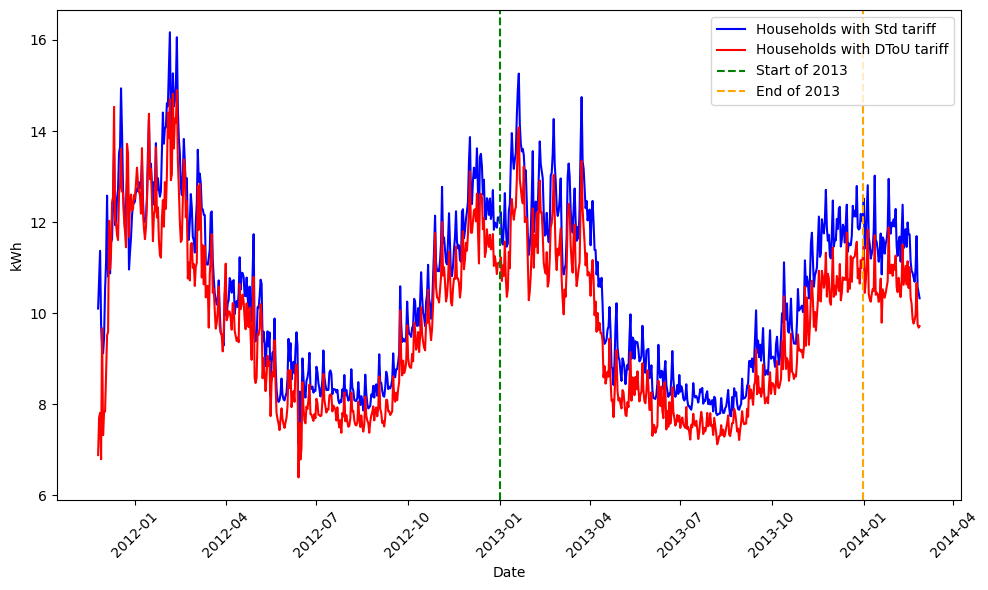

In [105]:
# Step 6: Plotting the data
plt.figure(figsize=(10, 6))

# Plot for group 1 (households with Std only)
plt.plot(avg_group_1_daily[2:-2].index, avg_group_1_daily[2:-2], label='Households with Std tariff', color='blue')

# Plot for group 2 (households with ToU at some point)
plt.plot(avg_group_2_daily[2:-2].index, avg_group_2_daily[2:-2], label='Households with DToU tariff', color='red')

# Add vertical lines for 01/01/2013 and 31/12/2013
plt.axvline(pd.to_datetime('2013-01-01'), color='green', linestyle='--', label='Start of 2013')
plt.axvline(pd.to_datetime('2013-12-31'), color='orange', linestyle='--', label='End of 2013')

# Add titles and labels
# plt.title('Average Daily kWh Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Images/av_daily_cons.png')
plt.show()

## Seasonal comparisons

In [15]:
def seasonal_tag(date):
    if (date.month == 6 and date.day >= 22) or (date.month == 7) or (date.month == 8) or (date.month == 9 and date.day <= 21):
        return 'Summer'
    elif (date.month == 9 and date.day >= 22) or (date.month == 10) or (date.month == 11) or (date.month == 12 and date.day <= 21):
        return 'Autumn'
    elif (date.month == 12 and date.day >= 22) or (date.month == 1) or (date.month == 2) or (date.month == 3 and date.day <= 21):
        return 'Winter'
    elif (date.month == 3 and date.day >= 22) or (date.month == 4) or (date.month == 5) or (date.month == 6 and date.day <= 21):
        return 'Spring'
    else:
        return 'Error'

In [16]:
# Time vars
df_daily_averages = pd.DataFrame(group_1_daily.groupby('Date')['kwh_hh'].mean()).reset_index()
df_daily_averages['kwh_hh_treat'] = group_2_daily.groupby('Date')['kwh_hh'].mean().values
df_daily_averages.rename(columns={'kwh_hh':'kwh_hh_control'}, inplace=True)

df_daily_averages['Season'] = df_daily_averages['Date'].apply(seasonal_tag)
df_daily_averages['Month'] = pd.to_datetime(df_daily_averages['Date']).dt.month
df_daily_averages['Year'] = pd.to_datetime(df_daily_averages['Date']).dt.year

df_daily_averages.head()

,Date,kwh_hh_control,kwh_hh_treat,Season,Month,Year
0,2011-11-23,7.430000,4.327500,Autumn,11,2011
1,2011-11-24,8.998333,6.111750,Autumn,11,2011
2,2011-11-25,10.102885,6.886333,Autumn,11,2011
3,2011-11-26,10.706257,7.709500,Autumn,11,2011
4,2011-11-27,11.371486,7.813500,Autumn,11,2011


In [17]:
# Differences between treatment and control
df_daily_averages['diff_treat_control'] = df_daily_averages['kwh_hh_control'] - df_daily_averages['kwh_hh_treat']
df_daily_averages

,Date,kwh_hh_control,kwh_hh_treat,Season,Month,Year,diff_treat_control
0,2011-11-23,7.430000,4.327500,Autumn,11,2011,3.102500
1,2011-11-24,8.998333,6.111750,Autumn,11,2011,2.886583
2,2011-11-25,10.102885,6.886333,Autumn,11,2011,3.216551
3,2011-11-26,10.706257,7.709500,Autumn,11,2011,2.996757
4,2011-11-27,11.371486,7.813500,Autumn,11,2011,3.557986
...,...,...,...,...,...,...,...
824,2014-02-24,10.580187,9.759439,Winter,2,2014,0.820748
825,2014-02-25,10.453365,9.683862,Winter,2,2014,0.769503
826,2014-02-26,10.329026,9.716652,Winter,2,2014,0.612374
827,2014-02-27,10.506416,9.776561,Winter,2,2014,0.729855


In [18]:
# Define a df for averages 
df_daily_averages_plot = df_daily_averages[(df_daily_averages['Year']>=2012) & (df_daily_averages['Year']<=2013)]

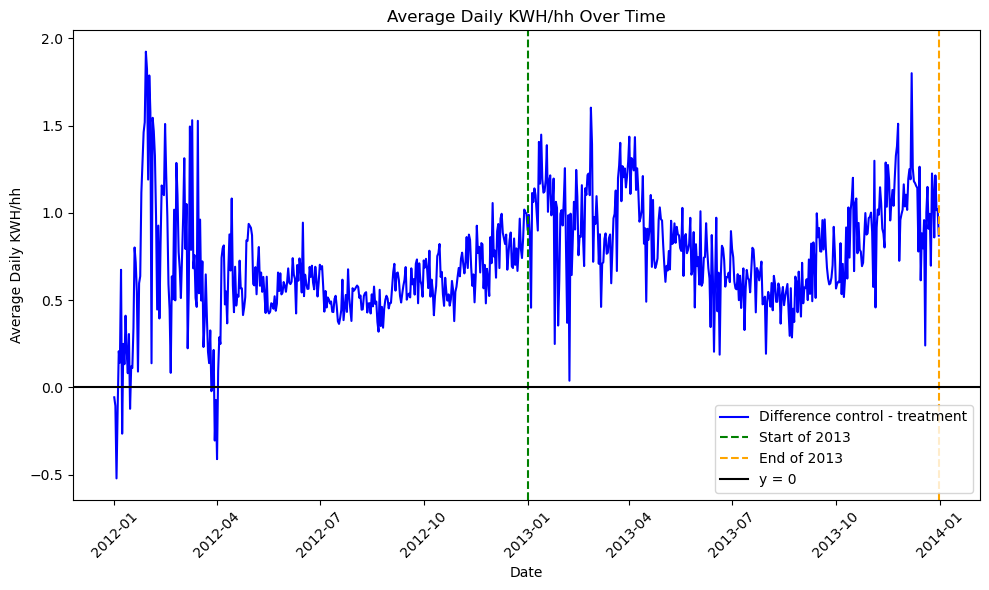

In [19]:

plt.figure(figsize=(10, 6))

# Plot for group 1 (households with Std only)
plt.plot(df_daily_averages_plot['Date'], df_daily_averages_plot['diff_treat_control'], label='Difference control - treatment', color='blue')

# Add lines for 01/01/2013 and 31/12/2013 and y = 0
plt.axvline(pd.to_datetime('2013-01-01'), color='green', linestyle='--', label='Start of 2013')
plt.axvline(pd.to_datetime('2013-12-31'), color='orange', linestyle='--', label='End of 2013')
plt.axhline(y=0, color='black', linestyle='-', label='y = 0')

# Add titles and labels
plt.title('Average Daily KWH/hh Over Time')
plt.xlabel('Date')
plt.ylabel('Average Daily KWH/hh')
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
av_treat_2012 = df_daily_averages[df_daily_averages['Year'] == 2012]['kwh_hh_treat'].mean()
av_treat_2013 = df_daily_averages[df_daily_averages['Year'] == 2013]['kwh_hh_treat'].mean()

av_control_2012 = df_daily_averages[df_daily_averages['Year'] == 2012]['kwh_hh_control'].mean()
av_control_2013 = df_daily_averages[df_daily_averages['Year'] == 2013]['kwh_hh_control'].mean()

av_diff_2012 = df_daily_averages[df_daily_averages['Year'] == 2012]['diff_treat_control'].mean()
av_diff_2013 = df_daily_averages[df_daily_averages['Year'] == 2013]['diff_treat_control'].mean()

print('Average for treatment group in 2012:', round(av_treat_2012,4))
print('Average for control group in 2012:', round(av_control_2012,4))
print('-------------------------------------------')
print('Average for treatment group in 2013:', round(av_treat_2013,4))
print('Average for control group in 2013:', round(av_control_2013,4))
print('-------------------------------------------')
print('Average for difference in 2012:', round(av_diff_2012,4))
print('Average for control group in 2013:', round(av_diff_2013,4))
print('-------------------------------------------')


Average for treatment group in 2012: 9.8624
Average for control group in 2012: 10.4863
-------------------------------------------
Average for treatment group in 2013: 9.4339
Average for control group in 2013: 10.2751
-------------------------------------------
Average for difference in 2012: 0.6239
Average for control group in 2013: 0.8413
-------------------------------------------


In [36]:
print(f'Average difference 2012: {av_diff_2012:.2f}')

Average difference 2012: 0.62


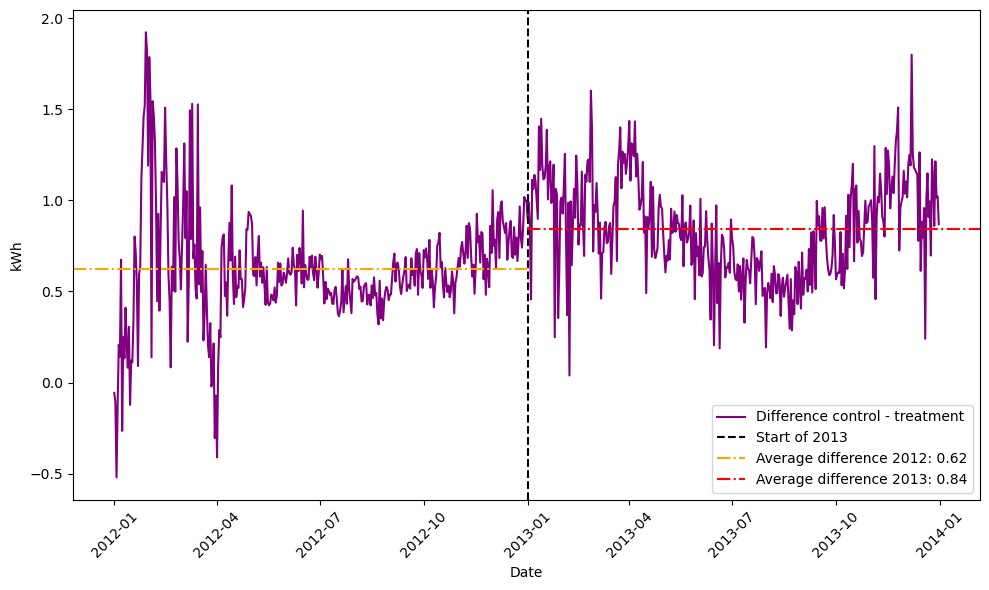

In [177]:
plt.figure(figsize=(10, 6))

df_daily_averages_plot = df_daily_averages[(df_daily_averages['Year']>=2012) & (df_daily_averages['Year']<=2013)]

# Plot for group 1 (households with Std only)
plt.plot(df_daily_averages_plot['Date'], df_daily_averages_plot['diff_treat_control'], label='Difference control - treatment', color='purple')

# Add lines for 01/01/2013 and 31/12/2013 and y = 0
plt.axvline(pd.to_datetime('2013-01-01'), color='black', linestyle='--', label='Start of 2013')
# plt.axvline(pd.to_datetime('2013-12-31'), color='orange', linestyle='--', label='End of 2013')
plt.axhline(y=av_diff_2012, xmin = 0, xmax = 0.5, color='orange', linestyle='-.', label=f'Average difference 2012: {av_diff_2012:.2f}')
plt.axhline(y=av_diff_2013, xmin = 0.5, xmax = 1, color='red', linestyle='-.', label=f'Average difference 2013: {av_diff_2013:.2f}')

# Add titles and labels
# plt.title('Average Daily KWH/hh Over Time')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
# plt.grid()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Images/av_daily_diff.png')
plt.show()

In [38]:
# DF to plot monthly differences
df_daily_averages_grouped = df_daily_averages_plot.groupby(['Month', 'Year'])['diff_treat_control'].mean().reset_index()
df_daily_averages_grouped.head()

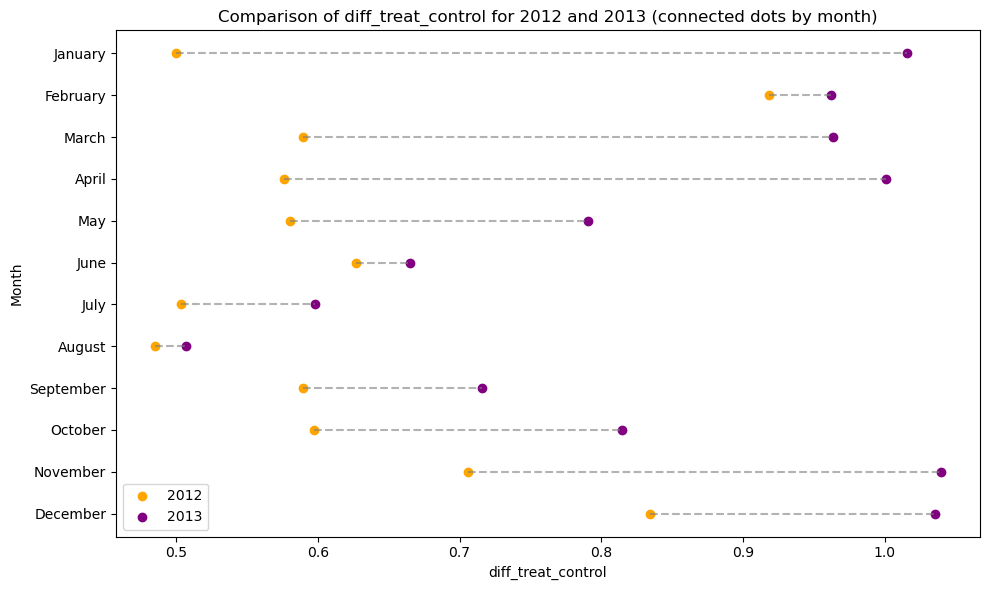

In [40]:
# Plot monthly differences
import calendar

# Filter the data for 2012 and 2013
df_2012 = df_daily_averages_grouped[df_daily_averages_grouped['Year'] == 2012].sort_values(by='Month')
df_2013 = df_daily_averages_grouped[df_daily_averages_grouped['Year'] == 2013].sort_values(by='Month')

# Create a mask to map month numbers to month names
month_names = df_2012['Month'].map(lambda x: calendar.month_name[x])

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Scatter plot for 2012 data (dots)
plt.scatter(df_2012['diff_treat_control'], df_2012['Month'], color='orange', label='2012', marker='o')

# Scatter plot for 2013 data (dots)
plt.scatter(df_2013['diff_treat_control'], df_2013['Month'], color='purple', label='2013', marker='o')

# Plot lines to connect dots for the same month across years (2012 to 2013)
for month in df_2012['Month']:
    y_2012 = df_2012[df_2012['Month'] == month]['diff_treat_control'].values[0]
    y_2013 = df_2013[df_2013['Month'] == month]['diff_treat_control'].values[0]
    
    # Plot a horizontal line connecting the same month from 2012 to 2013
    plt.plot([y_2012, y_2013], [month, month], color='gray', linestyle='--', alpha=0.6)

# Replace numeric y-ticks (months) with month names, and reverse order to have January at the top
plt.gca().invert_yaxis()  # This inverts the y-axis to display January at the top
plt.yticks(ticks=df_2012['Month'], labels=month_names)

# Add labels and title
plt.xlabel('diff_treat_control')
plt.ylabel('Month')
plt.title('Comparison of diff_treat_control for 2012 and 2013 (connected dots by month)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Include weather data in averages df

In [41]:
keep_cols = ['datetime', 'temp', 'feelslike', 'precip','cloudcover']
weather_2012 = pd.read_csv('London Weather data/London,UK 2012-01-01 to 2012-12-31.csv')
weather_2012 = weather_2012[keep_cols]

weather_2013 = pd.read_csv('London Weather data/London,UK 2013-01-01 to 2013-12-31.csv')
weather_2013 = weather_2013[keep_cols]


In [42]:
weather_2012.describe()

,temp,feelslike,precip,cloudcover
count,366.000000,366.000000,366.000000,366.000000
mean,11.411749,10.507377,1.800363,58.706557
std,5.153533,6.036240,4.085704,18.722917
min,-1.000000,-4.800000,0.000000,0.500000
25%,8.000000,6.200000,0.000000,48.800000
50%,11.050000,10.700000,0.020500,60.800000
75%,15.400000,15.400000,1.012500,71.725000
max,25.200000,25.400000,33.998000,100.000000


In [43]:
weather_2013.describe()

,temp,feelslike,precip,cloudcover
count,365.000000,365.000000,365.000000,365.000000
mean,10.966027,9.776712,0.874578,64.306575
std,5.924752,7.149336,2.302435,19.328028
min,-0.600000,-6.400000,0.000000,4.300000
25%,6.200000,4.000000,0.000000,53.800000
50%,10.700000,9.900000,0.003000,66.100000
75%,15.300000,15.300000,0.399000,78.700000
max,25.200000,25.500000,18.278000,99.200000


In [44]:
df_weather = pd.concat([weather_2013, weather_2012]).reset_index(drop = True)
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.sort_values(by = 'datetime', inplace = True)

In [45]:
len(df_weather)

731

In [46]:
df_weather.head()

,datetime,temp,feelslike,precip,cloudcover
365,2012-01-01,11.2,10.4,8.785,54.8
366,2012-01-02,6.0,2.8,10.943,31.8
367,2012-01-03,8.9,6.1,8.415,51.7
368,2012-01-04,7.2,3.1,0.000,62.3
369,2012-01-05,9.9,8.5,4.585,50.4


In [48]:
df_daily_averages_plot['Date'] = pd.to_datetime(df_daily_averages_plot['Date'])
df_weather_averages = df_daily_averages_plot.merge(df_weather, left_on='Date', right_on='datetime')
df_weather_averages

,Date,kwh_hh_control,kwh_hh_treat,Season,Month,Year,diff_treat_control,datetime,temp,feelslike,precip,cloudcover
0,2012-01-01,12.458407,12.515070,Winter,1,2012,-0.056663,2012-01-01,11.2,10.4,8.785,54.8
1,2012-01-02,12.740040,12.846070,Winter,1,2012,-0.106031,2012-01-02,6.0,2.8,10.943,31.8
2,2012-01-03,12.672975,13.194158,Winter,1,2012,-0.521183,2012-01-03,8.9,6.1,8.415,51.7
3,2012-01-04,12.724000,12.850298,Winter,1,2012,-0.126298,2012-01-04,7.2,3.1,0.000,62.3
4,2012-01-05,12.876140,12.668877,Winter,1,2012,0.207263,2012-01-05,9.9,8.5,4.585,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2013-12-27,11.837413,10.978088,Winter,12,2013,0.859324,2013-12-27,9.2,7.0,0.227,62.3
727,2013-12-28,11.864775,10.650277,Winter,12,2013,1.214498,2013-12-28,5.8,3.4,0.000,48.8
728,2013-12-29,12.180932,11.165529,Winter,12,2013,1.015403,2013-12-29,4.0,1.3,0.201,40.3
729,2013-12-30,12.022238,11.000525,Winter,12,2013,1.021713,2013-12-30,8.9,6.8,3.024,61.4


<Figure size 1000x600 with 0 Axes>

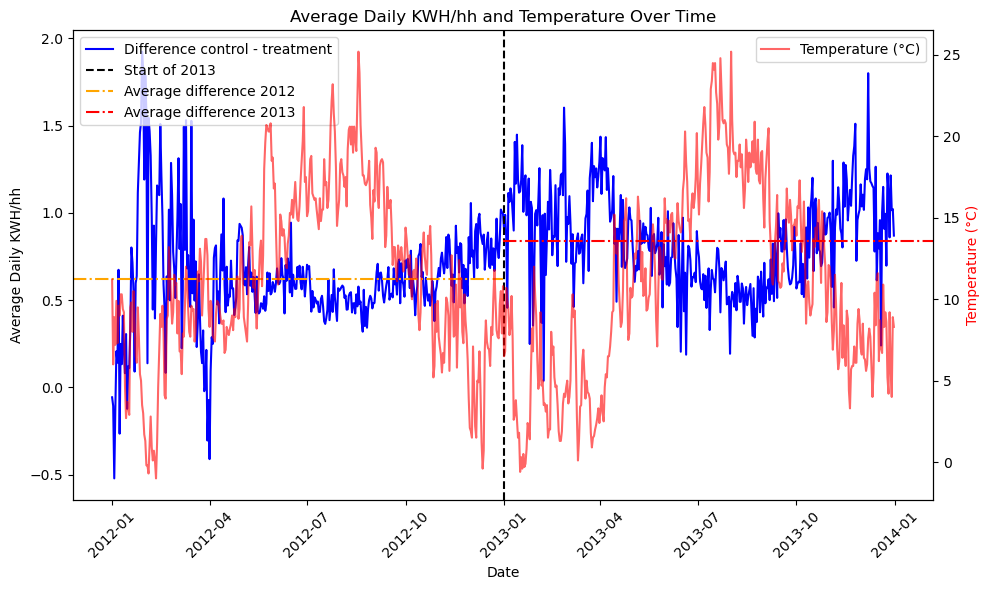

In [49]:
plt.figure(figsize=(10, 6))

# Create the main plot (for diff_treat_control)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for diff_treat_control (on the primary y-axis)
ax1.plot(df_weather_averages['Date'], df_weather_averages['diff_treat_control'], label='Difference control - treatment', color='blue')

# Add lines for 01/01/2013 and y = 0 (on the primary y-axis)
ax1.axvline(pd.to_datetime('2013-01-01'), color='black', linestyle='--', label='Start of 2013')
ax1.axhline(y=av_diff_2012, xmin=0, xmax=0.5, color='orange', linestyle='-.', label='Average difference 2012')
ax1.axhline(y=av_diff_2013, xmin=0.5, xmax=1, color='red', linestyle='-.', label='Average difference 2013')

# Titles and labels for primary y-axis
ax1.set_title('Average Daily KWH/hh and Temperature Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Daily KWH/hh')
ax1.legend(loc='upper left')

# Rotate x-axis labels for readability
ax1.tick_params(axis='x', rotation=45)

# Create secondary y-axis (for temperature)
ax2 = ax1.twinx()
ax2.plot(df_weather_averages['Date'], df_weather_averages['temp'], label='Temperature (°C)', color='red', linestyle='-', alpha=0.6)

# Labels and legend for secondary y-axis
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.legend(loc='upper right')

# Show the plot
fig.tight_layout()
plt.show()


## Analysis at household level

### Prepare right sample in terms of size and representativity of dates

In [50]:
df.head()

,LCLid,stdorToU,DateTime,kwh_hh,Date
0,MAC005251,Std,2013-12-19 20:00:00,0.347,2013-12-19
1,MAC005251,Std,2013-12-19 20:30:00,0.293,2013-12-19
2,MAC005251,Std,2013-12-19 21:00:00,0.284,2013-12-19
3,MAC005251,Std,2013-12-19 21:30:00,0.227,2013-12-19
4,MAC005251,Std,2013-12-19 22:00:00,0.397,2013-12-19


In [51]:
df.shape

(167932474, 5)

Let's sample the data. With 1.6M observations, it will be computationally expensive to do any analysis at the household level. 

We have the list `tou_households`, the households that partook in the program (treatment group). We can create the inverse list (control group), and then sample 10% of each list. 

In [52]:
std_households = df[df['stdorToU'] != 'ToU']['LCLid'].unique()

In [53]:
print('Number of treated households:', len(tou_households))
print('Number of untreated households:', len(std_households))

Number of treated households: 1123
Number of untreated households: 4443


In [54]:
df.head(15)

,LCLid,stdorToU,DateTime,kwh_hh,Date
0,MAC005251,Std,2013-12-19 20:00:00,0.347,2013-12-19
1,MAC005251,Std,2013-12-19 20:30:00,0.293,2013-12-19
2,MAC005251,Std,2013-12-19 21:00:00,0.284,2013-12-19
3,MAC005251,Std,2013-12-19 21:30:00,0.227,2013-12-19
4,MAC005251,Std,2013-12-19 22:00:00,0.397,2013-12-19
5,MAC005251,Std,2013-12-19 22:30:00,0.245,2013-12-19
6,MAC005251,Std,2013-12-19 23:00:00,0.169,2013-12-19
7,MAC005251,Std,2013-12-19 23:30:00,0.197,2013-12-19
8,MAC005251,Std,2013-12-20 00:00:00,0.221,2013-12-20
9,MAC005251,Std,2013-12-20 00:30:00,0.173,2013-12-20


I worry that we won't have more than anecdotal information for some households, due to starting the program late or dropping early. Many households don't join the program until late 2012.

In [116]:
# Convert Date column to pandas datetime format (if not already done)
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for the years 2012 and 2013 using the Date column
df_filtered = df[(df['Date'] >= '2012-01-01') & (df['Date'] <= '2013-12-31')]

# Group by Year-Month using pd.Grouper, and count unique households
month_participation_count = df_filtered.groupby(pd.Grouper(key='Date', freq='M'))['LCLid'].nunique()

# Display the head of the result
month_participation_count.head()

/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_35271/1415925638.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_participation_count = df_filtered.groupby(pd.Grouper(key='Date', freq='M'))['LCLid'].nunique()


Date
2012-01-31     581
2012-02-29     843
2012-03-31    1235
2012-04-30    2112
2012-05-31    3671
Freq: ME, Name: LCLid, dtype: int64

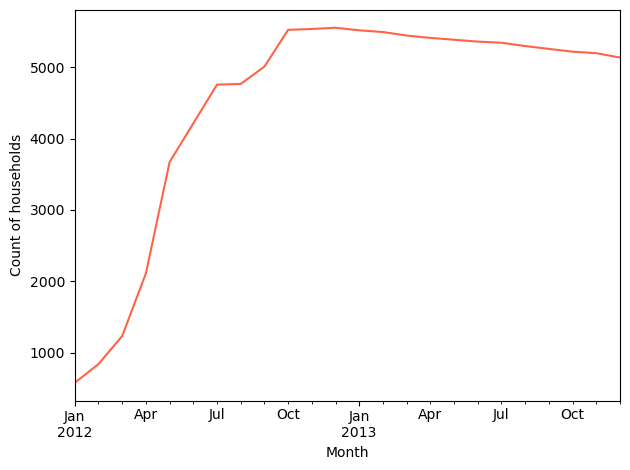

In [124]:
# Display the head of the result
month_participation_count.plot(color = 'tomato')
plt.xlabel('Month')
plt.ylabel('Count of households')
# plt.title('Count of households in LCL Project (2012-2013)')
plt.tight_layout()
plt.savefig('Images/experiment_uptake.png')
plt.show()

Let's filter the dataframe to keep only the households who were in the sample for all months in both 2012 and 2013. 

In [55]:
# Filter the data for 2012 and 2013
df_filtered = df[df['Year'].isin([2012, 2013])]

# Group by LCLid, Year, and Month to count the number of unique months each household has data for
household_month_count = df_filtered.groupby(['LCLid', 'Year'])['Month'].nunique().unstack(fill_value=0)

# Keep only households that have data for 12 or more months in both 2012 and 2013
valid_households = household_month_count[(household_month_count[2012] >= 12) & (household_month_count[2013] >= 12)].index

# Filter the original dataframe to keep only valid households
df_valid = df[df['LCLid'].isin(valid_households)]

In [56]:
print('Number of valid households:', len(valid_households))
household_month_count.head(15)

Number of valid households: 520


Year,2012,2013
LCLid,,
MAC000002,3,12
MAC000003,11,12
MAC000004,8,12
MAC000005,7,12
MAC000006,12,12
MAC000007,4,12
MAC000008,8,10
MAC000009,4,12
MAC000010,4,12


In [57]:
std_valid_households = df_valid[df_valid['stdorToU'] != 'ToU']['LCLid'].unique()
tou_valid_households = df_valid[df_valid['stdorToU'] == 'ToU']['LCLid'].unique()

print('Number of treated households:', len(tou_valid_households))
print('Number of untreated households:', len(std_valid_households))

Number of treated households: 77
Number of untreated households: 443


In [58]:
len(df_valid)

19864224

That downscales the dataframe by an order of magnitude. 

In [59]:
df_valid.head(10)

,LCLid,stdorToU,DateTime,kwh_hh,Date,Year,Month
2000000,MAC000256,Std,2013-07-19 00:30:00,0.086,2013-07-19,2013,7
2000001,MAC000256,Std,2013-07-19 01:00:00,0.117,2013-07-19,2013,7
2000002,MAC000256,Std,2013-07-19 01:30:00,0.086,2013-07-19,2013,7
2000003,MAC000256,Std,2013-07-19 02:00:00,0.128,2013-07-19,2013,7
2000004,MAC000256,Std,2013-07-19 02:30:00,0.076,2013-07-19,2013,7
2000005,MAC000256,Std,2013-07-19 03:00:00,0.131,2013-07-19,2013,7
2000006,MAC000256,Std,2013-07-19 03:30:00,0.078,2013-07-19,2013,7
2000007,MAC000256,Std,2013-07-19 04:00:00,0.109,2013-07-19,2013,7
2000008,MAC000256,Std,2013-07-19 04:30:00,0.086,2013-07-19,2013,7
2000009,MAC000256,Std,2013-07-19 05:00:00,0.106,2013-07-19,2013,7


In [60]:
df_daily = df_valid.groupby(['LCLid', 'Date'])['kwh_hh'].sum().reset_index()
df_daily = df_daily[(df_daily['Date'].dt.year == 2012) | (df_daily['Date'].dt.year == 2013)]
df_daily['treat'] = df_daily['LCLid'].isin(tou_valid_households).astype(int)
df_daily

,LCLid,Date,kwh_hh,treat
0,MAC000006,2012-01-30,2.162,0
1,MAC000006,2012-01-31,3.906,0
2,MAC000006,2012-02-01,3.587,0
3,MAC000006,2012-02-02,3.416,0
4,MAC000006,2012-02-03,3.739,0
...,...,...,...,...
414723,MAC005555,2013-12-27,5.816,0
414724,MAC005555,2013-12-28,7.186,0
414725,MAC005555,2013-12-29,9.684,0
414726,MAC005555,2013-12-30,6.667,0


### Feature engineering

#### Date variables

In [61]:
# Create new columns for year, month, day of the week, and weekend
df_daily['year'] = df_daily['Date'].dt.year
df_daily['month'] = df_daily['Date'].dt.month
df_daily['day_of_week'] = df_daily['Date'].dt.day_name()  # Returns the name of the day
df_daily['is_weekend'] = (df_daily['Date'].dt.weekday >= 5).astype(int)  # True/False to 1/0 for weekends

# Create dummy variables for 'day_of_week', 'month', and 'year'
df_daily = pd.get_dummies(df_daily, columns=['day_of_week', 'month', 'year'], drop_first=True, dtype = int)

# Now your dummy variables should be integer-based.
df_daily.head()


,LCLid,Date,kwh_hh,treat,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2013
0,MAC000006,2012-01-30,2.162,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MAC000006,2012-01-31,3.906,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,MAC000006,2012-02-01,3.587,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MAC000006,2012-02-02,3.416,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,MAC000006,2012-02-03,3.739,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
print(df_daily.columns)

Index(['LCLid', 'Date', 'kwh_hh', 'treat', 'is_weekend', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2013'],
      dtype='object')


In [63]:
len(df_daily)

376769

#### Weather variables

In [64]:
df_daily = df_daily.merge(df_weather, left_on='Date', right_on='datetime').drop(columns=['datetime'])

#### Diff-in-diff variable 
- treat*year_2013

In [65]:
df_daily['treat_2013'] = df_daily['treat'] * df_daily['year_2013']

#### Acorn groups

From this Kaggle [dataset](https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london?select=informations_households.csv)

In [66]:
df_acorn = pd.read_excel('Additional experiment data/informations_households.xlsx')
df_acorn.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


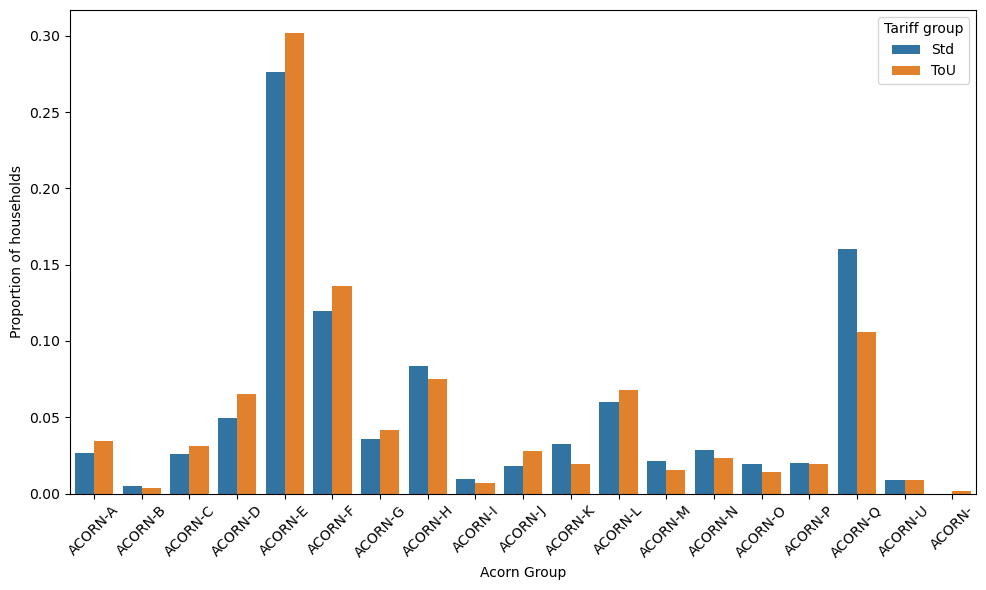

In [109]:
# Plot distributon of households by Acorn group
# Step 1: Calculate the counts of LCLid for each stdorToU and Acorn_grouped
df_counts = df_acorn.groupby(['stdorToU', 'Acorn'])['LCLid'].count().reset_index()

# Step 2: Calculate the proportion within each stdorToU group
df_counts['proportion'] = df_counts.groupby('stdorToU')['LCLid'].transform(lambda x: x / x.sum())


# Set the figure size
plt.figure(figsize=(10, 6))

palette = {
    'Std': 'tab:blue',
    'ToU': 'tab:orange',
}

# Step 3: Create the bar plot using seaborn to show proportions
bar_plot = sns.barplot(data=df_counts, x='Acorn', y='proportion', hue='stdorToU', palette=palette)

# Change the legend title
bar_plot.get_legend().set_title("Tariff group")

# Add titles and labels
plt.xlabel('Acorn Group')
plt.ylabel('Proportion of households')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('Images/tariffs_by_acorn_group.png')
plt.show()


In [67]:
# Merge with daily dataset
df_daily = df_daily.merge(df_acorn[['LCLid', 'Acorn']], on = 'LCLid', how='left')
df_daily.head()

,LCLid,Date,kwh_hh,treat,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,month_10,month_11,month_12,year_2013,temp,feelslike,precip,cloudcover,treat_2013,Acorn
0,MAC000006,2012-01-30,2.162,0,0,1,0,0,0,0,...,0,0,0,0,3.0,1.7,0.299,70.1,0,ACORN-Q
1,MAC000006,2012-01-31,3.906,0,0,0,0,0,0,1,...,0,0,0,0,1.7,-0.8,0.298,65.0,0,ACORN-Q
2,MAC000006,2012-02-01,3.587,0,0,0,0,0,0,0,...,0,0,0,0,1.3,-3.6,0.000,35.0,0,ACORN-Q
3,MAC000006,2012-02-02,3.416,0,0,0,0,0,1,0,...,0,0,0,0,-0.2,-4.8,0.000,10.4,0,ACORN-Q
4,MAC000006,2012-02-03,3.739,0,0,0,0,0,0,0,...,0,0,0,0,-0.2,-3.1,0.000,28.5,0,ACORN-Q


In [68]:
# Encode acorn variable. 
# Since the order have a meaning (group A is more affluent than B, and so on), it makes sense to have an ordinal encoder
enc = OrdinalEncoder()
df_daily['Acorn_enc'] = enc.fit_transform(df_daily[['Acorn']])
df_daily.head()

,LCLid,Date,kwh_hh,treat,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,month_11,month_12,year_2013,temp,feelslike,precip,cloudcover,treat_2013,Acorn,Acorn_enc
0,MAC000006,2012-01-30,2.162,0,0,1,0,0,0,0,...,0,0,0,3.0,1.7,0.299,70.1,0,ACORN-Q,16.0
1,MAC000006,2012-01-31,3.906,0,0,0,0,0,0,1,...,0,0,0,1.7,-0.8,0.298,65.0,0,ACORN-Q,16.0
2,MAC000006,2012-02-01,3.587,0,0,0,0,0,0,0,...,0,0,0,1.3,-3.6,0.000,35.0,0,ACORN-Q,16.0
3,MAC000006,2012-02-02,3.416,0,0,0,0,0,1,0,...,0,0,0,-0.2,-4.8,0.000,10.4,0,ACORN-Q,16.0
4,MAC000006,2012-02-03,3.739,0,0,0,0,0,0,0,...,0,0,0,-0.2,-3.1,0.000,28.5,0,ACORN-Q,16.0


#### Tariffs

In [69]:
df_tariffs = pd.read_excel('Additional experiment data/Tariffs.xlsx')
df_tariffs.head()

,TariffDateTime,Tariff
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal


In [73]:
df_tariffs['Tariff'].value_counts(normalize=True)

Tariff
Normal    0.860274
Low       0.094749
High      0.044977
Name: proportion, dtype: float64

In [70]:
# Ensure that TariffDateTime is a datetime object
df_tariffs['TariffDateTime'] = pd.to_datetime(df_tariffs['TariffDateTime'])

# Create a new column for the date (without the time)
df_tariffs['Date'] = df_tariffs['TariffDateTime'].dt.date

# Group by Date and calculate the required columns
df_tariffs_transformed = df_tariffs.groupby('Date').agg(
    High_occurred=('Tariff', lambda x: int('High' in x.values)),  # Boolean if 'High' occurred
    Low_occurred=('Tariff', lambda x: int('Low' in x.values)),    # Boolean if 'Low' occurred
    High_count=('Tariff', lambda x: (x == 'High').sum()),    # Count of 'High'
    Low_count=('Tariff', lambda x: (x == 'Low').sum())       # Count of 'Low'
).reset_index()

df_tariffs_transformed.rename(columns = {
    'High_occurred':'got_high_signal',
    'Low_occurred':'got_low_signal',
    'High_count':'high_signal_intensity',
    'Low_count':'low_signal_intensity'
}, inplace = True)

# Display the first few rows of the new daily-level dataframe
df_tariffs_transformed.head()


,Date,got_high_signal,got_low_signal,high_signal_intensity,low_signal_intensity
0,2013-01-01,0,0,0,0
1,2013-01-02,0,0,0,0
2,2013-01-03,0,0,0,0
3,2013-01-04,0,1,0,6
4,2013-01-05,0,0,0,0


In [71]:
# Create a date range for all days in 2012
date_range_2012 = pd.date_range(start='2012-01-01', end='2012-12-31', freq='D')

# Create the artificial DataFrame for 2012 with zero values for all required columns
df_2012 = pd.DataFrame({
    'Date': date_range_2012.date,  # Convert Timestamp to date
    'got_high_signal': 0,
    'got_low_signal': 0,
    'high_signal_intensity': 0,
    'low_signal_intensity': 0
})

# Concatenate the 2012 dataframe with the existing 2013 dataframe (df_daily)
df_tariffs_transformed = pd.concat([df_2012, df_tariffs_transformed], ignore_index=True)

# Optionally, sort by date
df_tariffs_transformed = df_tariffs_transformed.sort_values(by='Date').reset_index(drop=True)

# Display the first few rows of the combined dataframe
df_tariffs_transformed.head()


,Date,got_high_signal,got_low_signal,high_signal_intensity,low_signal_intensity
0,2012-01-01,0,0,0,0
1,2012-01-02,0,0,0,0
2,2012-01-03,0,0,0,0
3,2012-01-04,0,0,0,0
4,2012-01-05,0,0,0,0


In [380]:
# Merge with main daily dataset
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_tariffs_transformed['Date'] = pd.to_datetime(df_tariffs_transformed['Date'])
df_daily = df_daily.merge(df_tariffs_transformed, on = 'Date', how = 'left')

In [384]:
# Correct for who received alert - only people in treatment group
for col in ['got_high_signal', 'got_low_signal', 'high_signal_intensity', 'low_signal_intensity']:
    df_daily[col] = df_daily[col]*df_daily['treat_2013']
df_daily.head()

,LCLid,Date,kwh_hh,treat,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,...,temp,feelslike,precip,cloudcover,Acorn,Acorn_enc,got_high_signal,got_low_signal,high_signal_intensity,low_signal_intensity
0,MAC000006,2012-01-30,2.162,0,0,1,0,0,0,0,...,3.0,1.7,0.299,70.1,ACORN-Q,16.0,0,0,0,0
1,MAC000006,2012-01-31,3.906,0,0,0,0,0,0,1,...,1.7,-0.8,0.298,65.0,ACORN-Q,16.0,0,0,0,0
2,MAC000006,2012-02-01,3.587,0,0,0,0,0,0,0,...,1.3,-3.6,0.000,35.0,ACORN-Q,16.0,0,0,0,0
3,MAC000006,2012-02-02,3.416,0,0,0,0,0,1,0,...,-0.2,-4.8,0.000,10.4,ACORN-Q,16.0,0,0,0,0
4,MAC000006,2012-02-03,3.739,0,0,0,0,0,0,0,...,-0.2,-3.1,0.000,28.5,ACORN-Q,16.0,0,0,0,0


In [387]:
print(df_daily['got_high_signal'].value_counts())
print(df_daily['got_low_signal'].value_counts())
print(df_daily['high_signal_intensity'].value_counts())
print(df_daily['low_signal_intensity'].value_counts())

got_high_signal
0    370841
1      5928
Name: count, dtype: int64
got_low_signal
0    368764
1      8005
Name: count, dtype: int64
high_signal_intensity
0     370841
12      2387
6       1693
2        462
10       462
24       385
14       231
4        154
8         77
34        77
Name: count, dtype: int64
low_signal_intensity
0     368764
10      2079
6       1461
26      1232
12       770
24       539
36       462
2        462
4        231
38       231
14       154
32       154
48       153
30        77
Name: count, dtype: int64


### Save data with extra features

In [389]:
df_daily.to_csv('valid_data_fe.csv', index = False)